In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader

import csv
import numpy as np

import math
import random

import optuna

import joblib

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_SEQ = 1
SEQ_LENGTH = 365*2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3
OUTPUT_DIM = 1

N_CATCHMENT=2346

EPOCHS = 500

VAL_STEP_SIZE = 100

PATIENCE = 25

use_amp = True
compile_model = False
if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [4]:
class Forcing_Data_back(Dataset):
    def __init__(
        self, fpath="data/Caravan/data3f_train.csv", record_length=5843, n_feature=3
    ):
        data_raw = np.genfromtxt(fpath, delimiter=",", skip_header=1)

        # normalization and then reshape to catchment*record*feature
        x = torch.from_numpy(data_raw[:, 0:n_feature]).to(dtype=torch.float32)
        self.x = x.view(-1, record_length, n_feature).contiguous()

        # normalization and then reshape to catchment*record
        y = torch.from_numpy(data_raw[:, n_feature]).to(dtype=torch.float32)
        self.y = y.view(-1, record_length).contiguous()

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]


In [5]:
class Random_Index_Generator:
    def __init__(self, catchment_number=749, record_length=5843):
        self.catchment_number = catchment_number
        self.record_length = record_length

    def generate_random_consecutive_numbers(
        self, n_seq=1, batch_size=64, seq_length=100
    ):
        selected_catchments = np.random.choice(
            self.catchment_number, size=batch_size, replace=False
        )

        selected_starting_index = np.random.choice(
            self.record_length - seq_length + 1, size=batch_size * n_seq, replace=True
        )

        selected_ending_index = selected_starting_index + seq_length

        return selected_catchments, selected_starting_index, selected_ending_index


In [6]:
class Random_Batch_Generator:
    def __init__(self, dataset, index_gen, record_length):
        self.dataset = dataset
        self.index_gen = index_gen
        self.record_length = record_length

    def get_batch(self, n_seq=1, batch_size=64, seq_length=730, n_feature=3):

        (
            selected_catchments,
            selected_starting_index,
            selected_ending_index,
        ) = self.index_gen.generate_random_consecutive_numbers(
            n_seq, batch_size, seq_length
        )

        xs_batch = torch.ones([n_seq, batch_size, seq_length, n_feature])
        ys_batch = torch.ones([n_seq, batch_size, seq_length])

        for i in range(n_seq):

            for j in range(batch_size):
                xs_batch[i, j, :, :] = self.dataset.x[
                    selected_catchments[j],
                    selected_starting_index[j + i * batch_size] : selected_ending_index[
                        j + i * batch_size
                    ],
                    :,
                ]
                ys_batch[i, j, :] = self.dataset.y[
                    selected_catchments[j],
                    selected_starting_index[j + i * batch_size] : selected_ending_index[
                        j + i * batch_size
                    ],
                ]

        selected_catchments = torch.from_numpy(selected_catchments)

        return xs_batch, ys_batch, selected_catchments


In [7]:
class Forcing_Data(Dataset):
    def __init__(
        self,
        fpath="data/data_train_w_missing.csv",
        record_length=7304,
        n_feature=3,
        storge_device="cpu",
        seq_length=730,
        target_seq_length=365,
        base_length=365,
    ):
        data_raw = np.genfromtxt(fpath, delimiter=",", skip_header=1)

        # normalization and then reshape to catchment*record*feature
        x = torch.from_numpy(data_raw[:, 0:n_feature]).to(dtype=torch.float32)
        x = x.view(-1, record_length, n_feature).contiguous()
        self.x = x.to(storge_device)

        # normalization and then reshape to catchment*record
        y = torch.from_numpy(data_raw[:, n_feature]).to(dtype=torch.float32)
        y = y.view(-1, record_length).contiguous()
        self.y = y.to(storge_device)

        self.n_catchment = y.shape[0]

        self.n_feature = n_feature

        self.record_length = self.x.shape[1]
        self.seq_length = seq_length
        self.target_seq_length = target_seq_length
        self.base_length = base_length

        self.storge_device = storge_device

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

    def get_random_batch(self, batch_size=64):
        # This fuction return a input and output pair for each catchment
        # reference: https://medium.com/@mbednarski/understanding-indexing-with-pytorch-gather-33717a84ebc4
        # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms

        selected_catchment_index = torch.randint(
            low=0, high=self.n_catchment, size=(batch_size,), device=self.storge_device
        )

        x_sub = torch.index_select(self.x, dim=0, index=selected_catchment_index)
        y_sub = torch.index_select(self.y, dim=0, index=selected_catchment_index)

        # randomly selects a starting time step for each catchment
        index = torch.randint(
            low=0,
            high=self.record_length - self.seq_length + 1,
            size=(batch_size,),
            device=self.storge_device,
        )

        # expand the index to have the length of seq_length, adding 0 to seq_length to get correct index
        index_y = index.unsqueeze(-1).repeat(1, self.seq_length) + torch.arange(
            self.seq_length, device=self.storge_device
        )
        index_x = index_y.unsqueeze(-1).repeat(1, 1, self.n_feature)

        # use gather function to output values
        x_batch, y_batch = x_sub.gather(dim=1, index=index_x), y_sub.gather(
            dim=1, index=index_y
        )

        return (
            x_batch,
            y_batch[:, self.base_length :],
            selected_catchment_index,
        )

    def get_val_batch(self):
        n_years = math.ceil(
            (self.record_length - self.base_length) / self.target_seq_length
        )

        out_x = (
            torch.ones(
                [n_years, self.n_catchment, self.seq_length, self.n_feature],
                device=self.storge_device,
            )
            * torch.nan
        )
        out_y = (
            torch.ones(
                [n_years, self.n_catchment, self.seq_length], device=self.storge_device
            )
            * torch.nan
        )

        for i in range(n_years):
            start_record_ind = self.base_length * i

            if i == n_years - 1:
                end_record_ind = self.record_length

                out_x[i, :, 0 : (end_record_ind - start_record_ind), :] = self.x[
                    :, start_record_ind:end_record_ind, :
                ]
                out_y[i, :, 0 : (end_record_ind - start_record_ind)] = self.y[
                    :, start_record_ind:end_record_ind
                ]

            else:
                end_record_ind = start_record_ind + self.seq_length

                out_x[i, :, :, :] = self.x[:, start_record_ind:end_record_ind, :]
                out_y[i, :, :] = self.y[:, start_record_ind:end_record_ind]

        return out_x, out_y[:, :, self.base_length :]

In [8]:
class EarlyStopper:
    # Reference: https://stackoverflow.com/a/73704579/3361298

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [9]:
class TimeDistributed(nn.Module):
    # Reference: https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4

    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(
            -1, x.size(-1)
        )  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(
                x.size(0), -1, y.size(-1)
            )  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y


In [10]:
class Decoder(nn.Module):
    def __init__(
        self,
        latent_dim,
        feature_dim,
        lstm_hidden_dim,
        fc_hidden_dims,
        num_lstm_layers=1,
        output_dim=1,
        p=0.2,
    ):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.feature_dim = feature_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers

        self.lstm = nn.LSTM(
            self.feature_dim + self.latent_dim,
            self.lstm_hidden_dim,
            num_layers=self.num_lstm_layers,
            batch_first=True,
        )

        # LSTM to latent code
        self.fc_hidden_dims = fc_hidden_dims
        self.fc_layers = []
        self.p = p
        for i in range((len(self.fc_hidden_dims))):
            in_dim = self.lstm_hidden_dim if i == 0 else self.fc_hidden_dims[i - 1]
            out_dim = self.fc_hidden_dims[i]

            self.fc_layers += [nn.Linear(in_dim, out_dim)]
            self.fc_layers += [nn.ReLU()]
            self.fc_layers += [nn.Dropout(p=self.p)]

        self.output_dim = output_dim
        self.fc_layers += [nn.Linear(self.fc_hidden_dims[-1], self.output_dim)]

        self.fc_layers = TimeDistributed(
            nn.Sequential(*self.fc_layers), batch_first=True
        )
        
    def forward(self, inputs):
        out, (_, _) = self.lstm(inputs)
        out = self.fc_layers(out[:,BASE_LENGTH:,:])

        return out
    
    def decode(self, code, x):
        
        code = code.expand(x.shape[1], -1, -1).transpose(0, 1)

        x = torch.cat((code, x), 2)
        out = self.forward(x).squeeze()
        
        return out

In [11]:
# train_batch_gen = Random_Batch_Generator(
#     Forcing_Data("./data/data_train_w_missing.csv", record_length=7304),
#     Random_Index_Generator(catchment_number=2346, record_length=7304),
#     record_length=7304
# )
# train_val_batch_gen = Random_Batch_Generator(
#     Forcing_Data("./data/Caravan/data3f_train_val.csv", record_length=7669),
#     Random_Index_Generator(catchment_number=749, record_length=7669),
#     record_length=7669
# )
# val_batch_gen = Random_Batch_Generator(
#     Forcing_Data("./data/data_val_w_missing.csv", record_length=4017),
#     Random_Index_Generator(catchment_number=2346, record_length=4017),
#     record_length=4017
# )
# test_batch_gen = Random_Batch_Generator(
#     Forcing_Data("./data/Caravan/data3f_test.csv", record_length=4017),
#     Random_Index_Generator(catchment_number=749, record_length=4017),
#     record_length=4017
# )

dtrain = Forcing_Data(
    "data/data_train_w_missing.csv",
    record_length=7304,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = Forcing_Data(
    "data/data_val_w_missing.csv",
    record_length=4017,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [12]:
def mse_loss_with_nans(input, target):
    # Adapted from https://stackoverflow.com/a/59851632/3361298

    # Missing data are nans
    mask = torch.isnan(target)

    out = (input[~mask] - target[~mask]) ** 2
    loss = out.mean()

    return loss

def mse(target, pred): 
    mask = np.isnan(target)

    out = (pred[~mask] - target[~mask]) ** 2
    loss = out.mean()
    return loss

In [13]:
def predict_hydrogrpah(x, y, embedding, decoder):

    # put model into evaluation mode
    embedding, decoder = embedding.eval(), decoder.eval()

    # prediction have the same shape as the observation y
    preds = np.ones(y.shape)
    record_length = y.shape[1]

    # length of the target sequence in years
    n_years = math.floor((record_length - BASE_LENGTH) / TARGET_SEQ_LENGTH)

    for j in range(math.ceil(N_CATCHMENT / VAL_STEP_SIZE)):
        # iterate over catchments, evaluate VAL_STEP_SIZE catchments each time
        start_catchment_ind = j * VAL_STEP_SIZE
        end_catchment_ind = min((j + 1) * VAL_STEP_SIZE, N_CATCHMENT)

        # code of selected catchment
        selected_catchments = torch.from_numpy(
            np.arange(start_catchment_ind, end_catchment_ind)
        ).to(DEVICE)
        with torch.no_grad():
            code = embedding.forward(selected_catchments)

        # iterate over different years
        for k in range(n_years):
            start_record_ind = BASE_LENGTH + k * TARGET_SEQ_LENGTH
            end_record_ind = start_record_ind + TARGET_SEQ_LENGTH

            # dealing with the unique length of the last year record
            if k == (n_years - 1):
                end_record_ind = record_length

            # subsetting, base length is included
            x_sub = x[
                start_catchment_ind:end_catchment_ind,
                (start_record_ind - BASE_LENGTH) : end_record_ind,
                :,
            ].to(DEVICE)

            # pass through decoder, and store the result into `preds`
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                with torch.no_grad():
                    pred = decoder.decode(code, x_sub)
                    preds[
                        start_catchment_ind:end_catchment_ind,
                        start_record_ind:end_record_ind,
                    ] = (
                        pred.cpu().detach().numpy()
                    )

    return preds[:, BASE_LENGTH:]


In [14]:
def define_model(trial):
    
    lstm_hidden_dim=trial.suggest_int("lstm_hidden_dim", 4, 128)
    n_lstm_layers=trial.suggest_int("n_lstm_layers", 1, 2)
    n_fc_layers=trial.suggest_int("n_fc_layers", 1, 3)
    LATENT_DIM_power = trial.suggest_int("LATENT_DIM_power", 1, 2)
    LATENT_DIM = 2**LATENT_DIM_power
    
    drop_out_flag = trial.suggest_categorical("drop_out_flag", [True, False])
    
    if drop_out_flag:
        p = trial.suggest_float("dropout_rate", 0.2, 0.5)
    else:
        p = 0
    
    fc_hidden_dims = []
    for i in range(n_fc_layers):
        fc_dim = trial.suggest_int(f"fc_dim{i}", 4, 16)
        fc_hidden_dims.append(fc_dim)
        
    decoder = Decoder(
        latent_dim=LATENT_DIM,
        feature_dim=FORCING_DIM,
        lstm_hidden_dim=lstm_hidden_dim,
        fc_hidden_dims=fc_hidden_dims,
        num_lstm_layers=n_lstm_layers,
        output_dim=1,
        p=p,
    )
    
    embedding = nn.Embedding(N_CATCHMENT, LATENT_DIM)
    
    return embedding, decoder

In [15]:
def val_model(embedding, decoder, dataset, val_metric=mse):
    
    x, y = dataset.x, dataset.y
    
    preds = predict_hydrogrpah(x, y, embedding, decoder)
    obs = y[:,BASE_LENGTH:].cpu().detach().numpy()

    return val_metric(obs, preds)

In [16]:
def val_model(
    embedding,
    decoder,
    dataset,
    storge_device,
    computing_device,
    use_amp,
    val_metric,
    return_summary=True,
):
    """Validate embedding and decoder using the validation batch from dataset and val_metric.

    Args:
        embedding (Embedding): model that map catchment_id (Tensor.int) to latent code [tensor].
        decoder (Decoder): decorder model.
        dataset (Forcing_Data): dataset to be used in validation.
        val_metric (function, optional): compute gof metric. Defaults to mse_loss_with_nans.
        return_summary (bool, optional): whether the gof metric or the raw prediciton should be returned. Defaults to True.
        val_steps(int, optional): Number of catchments evaluated at each steps. Defaults to 500.

    Returns:
        tensor: gof metric or raw prediction.
    """
    x, y = dataset.get_val_batch()

    embedding.eval()
    decoder.eval()

    preds = torch.ones(size=y.shape, device=storge_device)

    n_catchments = y.shape[1]
    selected_catchments = torch.arange(n_catchments, device=computing_device)

    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
        with torch.no_grad():
            code = embedding(selected_catchments)
            for i in range(x.shape[0]):
                x_sub = x[i, :, :, :]
                preds[i, :, :] = decoder.decode(code, x_sub)

    if return_summary:
        out = val_metric(preds, y)
    else:
        out = preds

    return out

def val_model_mem_saving(
    embedding,
    decoder,
    dataset,
    storge_device,
    computing_device,
    use_amp,
    val_metric,
    return_summary,
    val_steps,
):
    """Validate embedding and decoder using the validation batch from dataset and val_metric.

    Args:
        embedding (Embedding): model that map catchment_id (Tensor.int) to latent code [tensor].
        decoder (Decoder): decorder model.
        dataset (Forcing_Data): dataset to be used in validation.
        val_metric (function, optional): compute gof metric. Defaults to mse_loss_with_nans.
        return_summary (bool, optional): whether the gof metric or the raw prediciton should be returned. Defaults to True.
        val_steps(int, optional): Number of catchments evaluated at each steps. Defaults to 500.

    Returns:
        tensor: gof metric or raw prediction.
    """
    x, y = dataset.get_val_batch()

    embedding.eval()
    decoder.eval()

    preds = torch.ones(size=y.shape, device=storge_device)
    n_catchments = y.shape[1]

    # iterate over years
    for i in range(x.shape[0]):
        # iterate over catchments
        for j in range(math.ceil(n_catchments / val_steps)):
            start_catchment_ind = j * val_steps
            end_catchment_ind = min((j + 1) * val_steps, n_catchments)
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                with torch.no_grad():
                    code = embedding(
                        torch.arange(
                            start=start_catchment_ind,
                            end=end_catchment_ind,
                            device=computing_device,
                        )
                    )
                    x_sub = x[i, start_catchment_ind:end_catchment_ind, :, :].to(
                        computing_device
                    )
                    preds[i, start_catchment_ind:end_catchment_ind, :] = decoder.decode(
                        code, x_sub
                    ).to(storge_device)

    if return_summary:
        out = val_metric(preds, y)
    else:
        out = preds

    return out

In [17]:
def objective(trial):

    losses = []
    val_losses = []

    # prepare early stopper
    early_stopper = EarlyStopper(patience=PATIENCE, min_delta=0)

    # define model
    embedding, decoder = define_model(trial)
    embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

    # define optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 3, 8)
    BATCH_SIZE = 2**batch_size_power
    TRAIN_STEPS = round(
        15 * N_CATCHMENT / BATCH_SIZE
    )  # year * catchment number / batch size

    # train model
    for epoch in range(EPOCHS):

        running_loss = 0.0

        for i in range(TRAIN_STEPS):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            # get training batch and pass to device
            (x_batch, y_batch, selected_catchments) = dtrain.get_random_batch(
                BATCH_SIZE
            )
            
            x_batch, y_batch, selected_catchments = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
                selected_catchments.to(computing_device),
            )

            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(selected_catchments)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = mse_loss_with_nans(out, y_batch)

            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()

            with torch.no_grad():
                running_loss = running_loss + loss.cpu().detach().numpy()

        losses.append(running_loss)

        # # compute validation loss

        # val_error = val_model(embedding, decoder, dval)
        # val_losses.append(val_error)

        # trial.report(val_error, epoch)

        # # Handle pruning based on the intermediate value.
        # if trial.should_prune():
        #     torch.cuda.empty_cache()
        #     raise optuna.exceptions.TrialPruned()

        # # Early stop using early_stopper, break for loop
        # if early_stopper.early_stop(val_error):
        #     break

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return early_stopper.min_validation_loss

In [18]:
decoder = Decoder(
    latent_dim=4,
    feature_dim=FORCING_DIM,
    lstm_hidden_dim=25,
    fc_hidden_dims=[6],
    num_lstm_layers=1,
    output_dim=1,
    p=0,
)

embedding = nn.Embedding(N_CATCHMENT, 4)

In [19]:
EPOCHS = 100
losses = []
val_losses = []

# define model
embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

# define batch size
batch_size_power = 6
BATCH_SIZE = 2** batch_size_power
TRAIN_STEPS = round(15*N_CATCHMENT/BATCH_SIZE) # catchment number * year / batch si

# define optimizers
lr = 0.0017145938261308676
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr)

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# train model
for epoch in range(EPOCHS):

    running_loss = 0.0

    for i in range(TRAIN_STEPS):

        decoder_optimizer.zero_grad()
        embedding_optimizer.zero_grad()

        # put the models into training mode
        decoder.train()
        embedding.train()

        # get training batch and pass to device
        (x_batch, y_batch, selected_catchments) = dtrain.get_random_batch(
            BATCH_SIZE
        )
        
        x_batch, y_batch, selected_catchments = (
            x_batch.to(computing_device),
            y_batch.to(computing_device),
            selected_catchments.to(computing_device),
        )

        # slice batch for training
        with torch.autocast(
            device_type="cuda", dtype=torch.float16, enabled=use_amp
        ):
            code = embedding(selected_catchments)

            # pass through decoder
            out = decoder.decode(code, x_batch)

            # compute loss
            loss = mse_loss_with_nans(out, y_batch)

        scaler.scale(loss).backward()
        scaler.step(embedding_optimizer)
        scaler.step(decoder_optimizer)
        scaler.update()

        with torch.no_grad():
            running_loss = running_loss + loss.cpu().detach().numpy()

    losses.append(running_loss)

    # put the model in to evaluation model, compute validation loss
    embedding.eval()
    decoder.eval()
    
    # Handle pruning based on the intermediate value
    if memory_saving:
        val_loss = val_model_mem_saving(
            embedding=embedding,
            decoder=decoder,
            dataset=dval,
            storge_device=storge_device,
            computing_device=computing_device,
            use_amp=use_amp,
            val_metric=mse_loss_with_nans,
            return_summary=True,
            val_steps=VAL_STEPS,
        )
    else:
        val_loss = (
            val_model(
                embedding=embedding,
                decoder=decoder,
                dataset=dval,
                storge_device=storge_device,
                computing_device=computing_device,
                use_amp=use_amp,
                val_metric=mse_loss_with_nans,
                return_summary=True,
            )
            .detach()
            .cpu()
            .numpy()
        )
    val_losses.append(val_loss)
            
    losses.append(val_loss)
    
    print(f"val={val_loss}")

val=5.017515659332275
val=4.459843635559082
val=4.1187262535095215
val=4.044862270355225
val=3.7769598960876465
val=3.6994822025299072
val=3.4810004234313965
val=3.5082967281341553
val=3.3294506072998047
val=3.2971298694610596
val=3.2659692764282227
val=3.2660627365112305
val=3.171774387359619
val=3.209750175476074
val=3.150386333465576
val=3.0805978775024414
val=3.1052029132843018
val=3.0524260997772217
val=3.075756072998047
val=3.014307975769043
val=3.0627918243408203
val=3.010718822479248
val=3.109849214553833
val=2.924255609512329
val=3.0679218769073486
val=2.8861587047576904
val=2.9174699783325195
val=2.927917003631592
val=2.9803483486175537
val=2.9044899940490723
val=2.8398683071136475
val=2.899876356124878
val=2.8597230911254883
val=2.8272809982299805
val=2.884828805923462
val=2.9121720790863037
val=2.7782766819000244
val=2.8449289798736572
val=2.8970274925231934
val=2.777165412902832
val=2.7890841960906982
val=2.7966980934143066
val=2.8034019470214844
val=2.905522584915161
val=

In [20]:
out.shape

torch.Size([64, 365])

In [17]:
study.best_params

{'lstm_hidden_dim': 25,
 'n_lstm_layers': 1,
 'n_fc_layers': 1,
 'LATENT_DIM_power': 2,
 'drop_out_flag': False,
 'fc_dim0': 6,
 'lr': 0.0017145938261308676,
 'batch_size_power': 6}

In [31]:
study = optuna.create_study(study_name="base_model", direction="minimize", pruner=optuna.pruners.NopPruner())
study.optimize(objective, n_trials=5)

[I 2022-12-17 09:27:49,833] A new study created in memory with name: base_model
[I 2022-12-17 14:43:44,995] Trial 0 finished with value: 3.853461273099789 and parameters: {'lstm_hidden_dim': 45, 'n_lstm_layers': 1, 'n_fc_layers': 3, 'LATENT_DIM_power': 1, 'drop_out_flag': True, 'dropout_rate': 0.41512299159634236, 'fc_dim0': 14, 'fc_dim1': 13, 'fc_dim2': 16, 'lr': 1.7873488949281057e-05, 'batch_size_power': 5}. Best is trial 0 with value: 3.853461273099789.
[W 2022-12-17 15:02:21,274] Trial 1 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_4187/3481565355.py", line 61, in objective
    loss.backward()
  File "/root/miniconda3/lib/python3.8/site-packages/torch/_tensor.py", line 363, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  

KeyboardInterrupt: 

In [20]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    EPOCHS = min(stats, key=lambda k: stats[k]) + 1
    
    return EPOCHS

In [ ]:
joblib.dump(study, "data/Caravan/3f_study.pkl")

In [21]:
def get_final_models(loaded_study):
    
    EPOCHS = get_optimal_epochs(loaded_study)
    trial = loaded_study.best_trials[0]

    losses = []
    val_losses = []

    # define model
    embedding, decoder  = define_model(trial)
    embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    BATCH_SIZE = 2** batch_size_power
    TRAIN_STEPS = round(15*N_CATCHMENT/BATCH_SIZE) # catchment number * year / batch si

    # define optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr)
    
    
    # train model
    for epoch in range(EPOCHS):

        running_loss = 0.0

        for i in range(TRAIN_STEPS):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            (xs_batch, ys_batch, selected_catchments) = train_val_batch_gen.get_batch(
                n_seq=N_SEQ, batch_size=BATCH_SIZE, seq_length=SEQ_LENGTH
            )

            # divide batch and pass to device
            xs_batch, ys_batch, selected_catchments = (
                xs_batch.to(DEVICE),
                ys_batch.to(DEVICE),
                selected_catchments.to(DEVICE),
            )
            
            # slice batch for training
            x0, y0 = (xs_batch[0, :, :, :], ys_batch[0, :, :])
            code = embedding(selected_catchments)

            # pass through decoder
            out = decoder.decode(code, x0)

            # backprop
            a, b = out[:, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :], y0[:, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :],
            
            loss = criterion(a,b)

            loss.backward()
            embedding_optimizer.step()
            decoder_optimizer.step()

            with torch.no_grad():
                running_loss = running_loss + loss.cpu().detach().numpy()

        # put the model in to evaluation model, compute validation loss
        embedding.eval()
        decoder.eval()
                
        losses.append(running_loss)

    
    torch.cuda.empty_cache()
    
    return embedding, decoder

In [22]:
embedding, decoder = get_final_models(study)

In [23]:
torch.save(embedding.cpu(), "data/Caravan/embedding.pt")
torch.save(decoder.cpu(), "data/Caravan/decoder.pt")

In [25]:
embedding.to(DEVICE)
decoder.to(DEVICE)

Decoder(
  (lstm): LSTM(7, 25, batch_first=True)
  (fc_layers): Sequential(
    (0): TimeDistributed(
      (module): Linear(in_features=25, out_features=6, bias=True)
    )
    (1): ReLU()
    (2): TimeDistributed(
      (module): Dropout(p=0, inplace=False)
    )
    (3): TimeDistributed(
      (module): Linear(in_features=6, out_features=1, bias=True)
    )
  )
)

In [26]:
preds, y_true = val_model(embedding, decoder, test_batch_gen, return_summary = False)
preds, y_true = preds.cpu().numpy(), y_true.cpu().numpy()

In [ ]:
batch_gen=val_batch_gen

embedding = torch.load("data/Caravan/embedding.pt", map_location=torch.device('cpu'))
decoder = torch.load("data/Caravan/decoder.pt", map_location=torch.device('cpu'))
embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

val_model(embedding, decoder, batch_gen, val_metric=mean_squared_error)

1.8813870947642763

In [27]:
import HydroErr

gofs = np.ones(preds.shape[0])
kges = np.ones(preds.shape[0])

for i in range(preds.shape[0]):
    gofs[i] = r2_score(y_true = y_true[i,:],y_pred=preds[i,:])
    kges[i] = HydroErr.kge_2009(simulated_array=preds[i,:], observed_array=y_true[i,:])

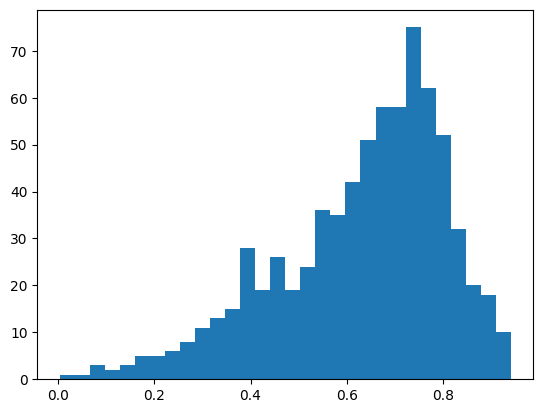

In [28]:
plt.hist(gofs[gofs>0], bins = 30)
plt.show()

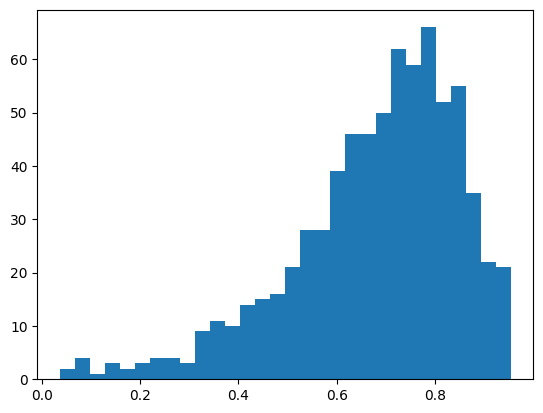

In [29]:
plt.hist(kges[kges>0], bins = 30)
plt.show()

In [30]:
kges.mean()

0.6425069517130905

In [41]:
np.savetxt("./data/CAMELS_US/kges.csv", kges, delimiter=",")

In [ ]:
i = 8
plt.plot(y_true[i,:])
plt.plot(preds[i,:])


In [ ]:
for j in range(math.ceil(N_CATCHMENT / 100)):
    # iterate over catchment
    start_catchment_ind = j * 100  # evaluate 100 catchments each time
    end_catchment_ind = min((j + 1) * 100, N_CATCHMENT)

    x_val, y_val = val_batch_gen.get_batch(
        selected_catchments=[
            a for a in range(start_catchment_ind, end_catchment_ind)
        ]
    )
    
    x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)

    code = embedding(
        torch.from_numpy(np.arange(start_catchment_ind, end_catchment_ind)).to(DEVICE)
    )

    x_val = x_val.transpose(0, 1)

    for k in range(x_val.shape[0]):
        # iterate over each year
        start_record_ind = (k + 1) * (SEQ_LENGTH - TARGET_SEQ_LENGTH)
        end_record_ind = start_record_ind + TARGET_SEQ_LENGTH

        x_val_sub = x_val[k, :, :, :].squeeze()
        preds[
            start_catchment_ind:end_catchment_ind,
            start_record_ind:end_record_ind,
        ] = decoder.decode(code, x_val_sub)[
            :, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :
        ]


In [ ]:
preds[start_catchment_ind:end_catchment_ind, start_record_ind:end_record_ind]

In [ ]:
preds = torch.ones(val_batch_gen.dataset.y.shape)
preds

In [ ]:
with torch.no_grad():
        (xs_batch, ys_batch, selected_catchments) = train_batch_gen.get_batch(
            n_seq=n_seq, batch_size=BATCH_SIZE, seq_length=SEQ_LENGTH
        )
        
        # divide batch and pass to device

        xs_batch, ys_batch, selected_catchments = xs_batch.to(DEVICE), ys_batch.to(DEVICE), selected_catchments.to(DEVICE)
        
        x0, y0 = (
            xs_batch[0, :, :, :],
            ys_batch[0, :, :]
        )

        code = embedding(selected_catchments)

        # pass through decoder
        out = decoder.decode(code, x0).squeeze()
    
data_plot = out.cpu().detach().numpy()

plt.plot(data_plot[1, (SEQ_LENGTH - TARGET_SEQ_LENGTH) : ])
plt.plot(y0[1, (SEQ_LENGTH-TARGET_SEQ_LENGTH):].cpu().detach().numpy())

In [ ]:
plt.plot(data_plot[24, (SEQ_LENGTH - TARGET_SEQ_LENGTH) : ])
plt.plot(y0[24, (SEQ_LENGTH-TARGET_SEQ_LENGTH):].cpu().detach().numpy())

In [ ]:
r2_score(y_true=y0[24, (SEQ_LENGTH-TARGET_SEQ_LENGTH):].cpu().detach().numpy(), y_pred=data_plot[24, (SEQ_LENGTH - TARGET_SEQ_LENGTH) : ])

In [ ]:
plt.scatter(code[:,0].cpu().detach().numpy(), code[:,1].cpu().detach().numpy())

In [ ]:
torch.save(embedding, "data/Caravan/embedding.pt")
torch.save(decoder, "data/Caravan/decoder.pt")